In [1]:
from utz import *
from utz import plots
import plotly.express as px
import plotly.graph_objects as go
import dask.dataframe as dd

from nj_crashes.paths import PLOTS_DIR
from njdot.data import START_YEAR, END_YEAR
from njdot.paths import DOT_DATA, CM_PQT

W, H = 1200, 700
save = partial(plots.save, dir=relpath(f'{PLOTS_DIR}/njdot'), png=(W, H), show='file')

In [2]:
overwrite = False

In [3]:
keys = [ 'Total Injured', 'Property Damage', 'Total Killed' ]
def load_year_county_months(year):
    df = read_parquet(f'{DOT_DATA}/{year}/NewJersey{year}Accidents.pqt')
    dt = df.Date.dt
    df['Property Damage'] = df.Severity.apply(lambda s: 1 if s == 'P' else 0)
    df['Year'] = dt.year.rename('Year')
    df['Month'] = dt.month.rename('Month')
    cm = (
        df
        .rename(columns={'County Name': 'County'})
        .groupby([ 'Year', 'Month', 'County', ])
        [keys]
        .sum()
        .reset_index()
    )

    cm['Date'] = cm.apply(lambda r: to_dt('%d-%02d' % (r.Year, r.Month)), axis=1)
    cm = cm[['Date', 'County'] + keys]
    return cm

In [4]:
%%time
cm = dd.concat([
    load_year_county_months(year)
    for year in range(START_YEAR, END_YEAR)
]).compute()
cm

CPU times: user 10.8 s, sys: 990 ms, total: 11.8 s
Wall time: 9.69 s


,Date,County,Total Injured,Property Damage,Total Killed
0,2001-01-01,ATLANTIC,340,494,2
1,2001-01-01,BERGEN,1053,2765,1
2,2001-01-01,BURLINGTON,347,818,6
3,2001-01-01,CAMDEN,525,957,0
4,2001-01-01,CAPE MAY,65,102,1
...,...,...,...,...,...
247,2022-12-01,SALEM,55,91,0
248,2022-12-01,SOMERSET,240,643,1
249,2022-12-01,SUSSEX,59,270,0
250,2022-12-01,UNION,459,1309,3


In [5]:
if not exists(CM_PQT) or overwrite:
    print(f'Writing {CM_PQT}')
    cm.to_parquet(CM_PQT)

Writing /Users/ryan/c/hccs/nj-crashes/njdot/data/cm.parquet


## Injuries, Property Damage, Deaths (Statewide, by Month)

In [6]:
sm = cm.groupby(cm.Date)[keys].sum(0)
sm

,Total Injured,Property Damage,Total Killed
Date,,,
2001-01-01,9549,22194,44
2001-02-01,7733,18171,61
2001-03-01,8696,17554,65
2001-04-01,8902,16600,41
2001-05-01,10483,18756,68
...,...,...,...
2022-08-01,6133,14167,55
2022-09-01,6229,15695,68
2022-10-01,7006,18713,61


In [7]:
grid = '#ccc'
def sm_plot(s, y, title, name, w=W, h=H):
    rolling = s.rolling(12).mean().rename('12mo avg')
    fig = px.bar(
        s,
        color_discrete_sequence=['black'],
        labels={ 'variable': '', 'value': y, 'Date': '', },
    )
    fig.add_trace(go.Scatter(x=rolling.index, y=rolling, name='12mo avg', line=dict(width=3, color='black')))
    return save(
        fig, name, title,
        bg='white',
        hoverx=True, hovertemplate='%{y:,d}',
        xgrid=grid, ygrid=grid,
        showlegend=False,
        png=(w, h),
    )

Wrote plot JSON to ../www/public/plots/njdot/ism.json
Wrote plot image to ../www/public/plots/njdot/ism.png


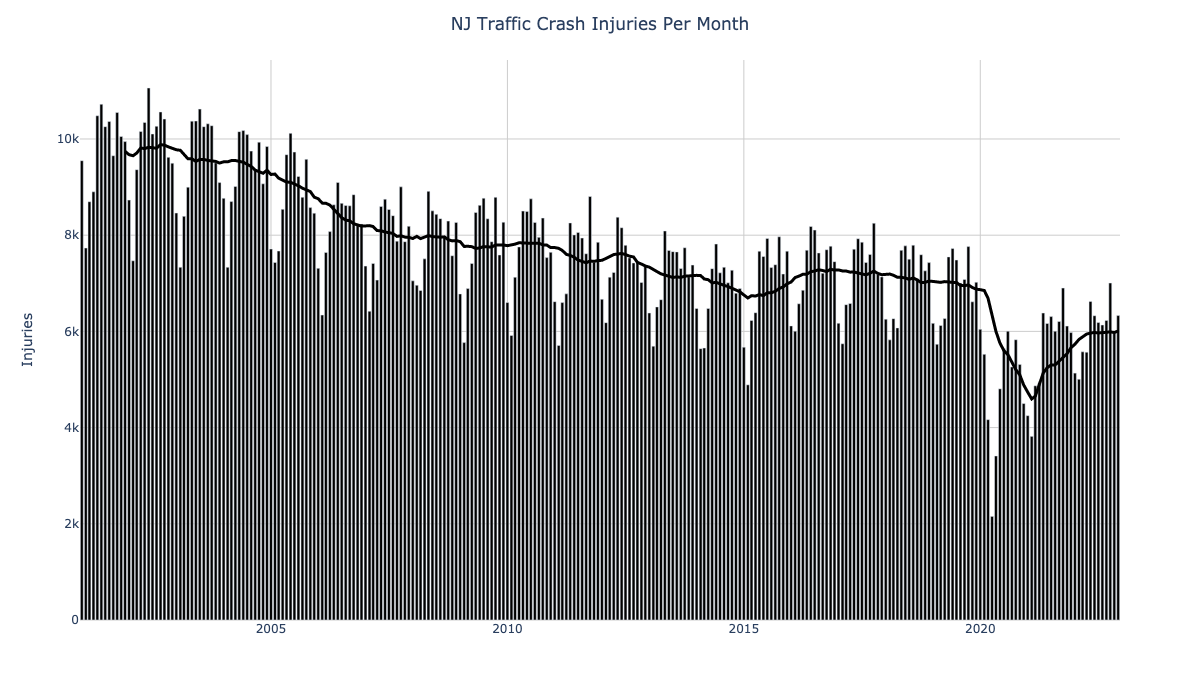

In [8]:
sm_plot(
    sm['Total Injured'],
    y='Injuries',
    title='NJ Car Crash Injuries Per Month',
    name='ism',
)#.show(config=dict(scrollZoom=True))

Wrote plot JSON to ../www/public/plots/njdot/psm.json
Wrote plot image to ../www/public/plots/njdot/psm.png


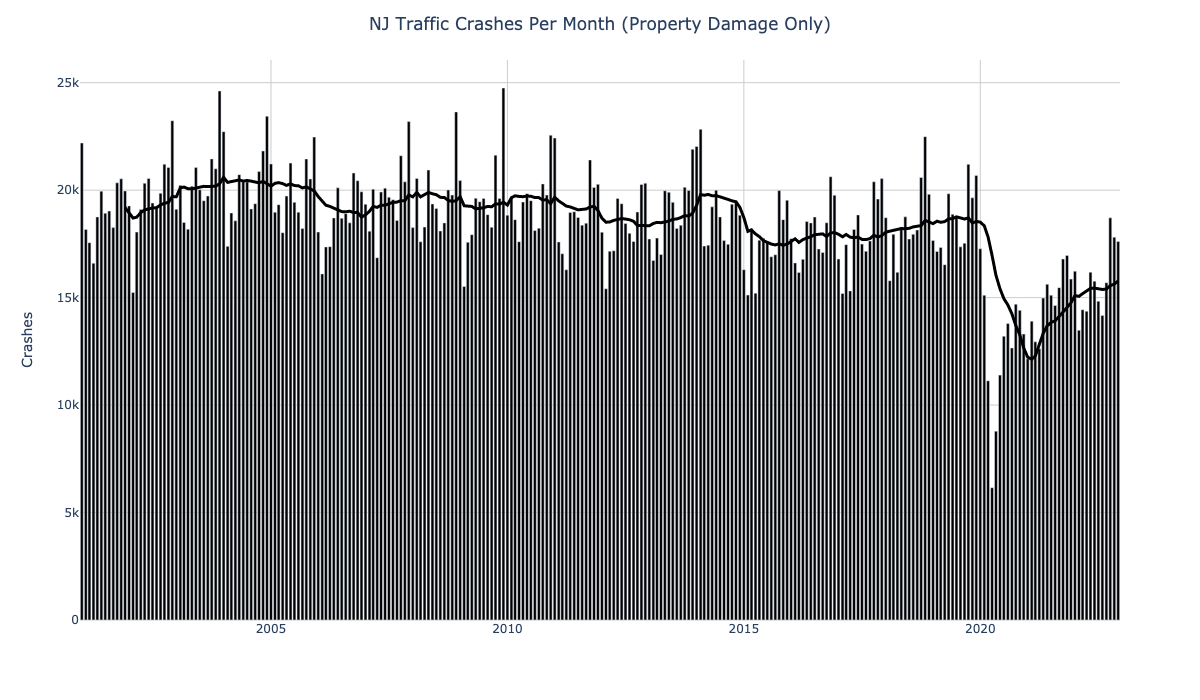

In [9]:
sm_plot(
    sm['Property Damage'],
    y='Crashes',
    title='NJ Car Crashes Per Month (Property Damage Only)',
    name='psm',
)

Wrote plot JSON to ../www/public/plots/njdot/dsm.json
Wrote plot image to ../www/public/plots/njdot/dsm.png


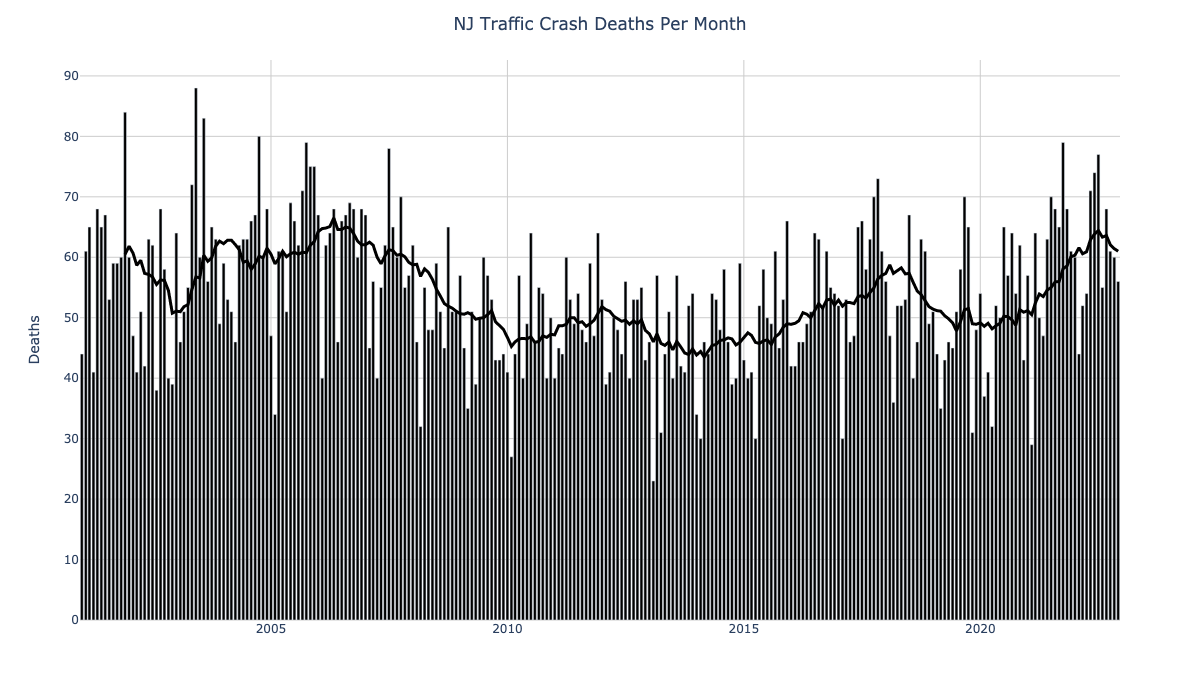

In [10]:
sm_plot(
    sm['Total Killed'],
    y='Deaths',
    title='NJ Car Crash Deaths Per Month',
    name='dsm',
)

## Injuries, Property Damage, Deaths (by County x Month)

In [11]:
cma = (
    cm
    .groupby('County')
    .apply(
        lambda df: (
            df
            .set_index(['County', 'Date'])
            .rolling(12)
            .mean()
            .reset_index()
        )
    )
    .reset_index(drop=True)
)
cma

,County,Date,Total Injured,Property Damage,Total Killed
0,ATLANTIC,2001-01-01,NaN,NaN,NaN
1,ATLANTIC,2001-02-01,NaN,NaN,NaN
2,ATLANTIC,2001-03-01,NaN,NaN,NaN
3,ATLANTIC,2001-04-01,NaN,NaN,NaN
4,ATLANTIC,2001-05-01,NaN,NaN,NaN
...,...,...,...,...,...
5539,WARREN,2022-08-01,61.916667,161.666667,1.666667
5540,WARREN,2022-09-01,58.166667,154.333333,1.750000
5541,WARREN,2022-10-01,54.500000,148.916667,1.500000
5542,WARREN,2022-11-01,50.000000,144.000000,1.500000


In [12]:
cma.isna().sum(1).value_counts()

0    5313
3     231
Name: count, dtype: int64

In [13]:
def cm_plot(title, y, name, yaxis=None, avgs=False, hovertemplate='%{y:,d}', w=W, h=H):
    if avgs:
        fig = go.Figure()
        counties = cma.County.unique()
        for county in counties:
            avg = cma[cma.County == county][['Date', y]]
            fig.add_trace(go.Scatter(x=avg.Date, y=avg[y], name=county))
    else:
        fig = px.line(
            cm,
            x='Date', y=y, color='County',
            labels={ 'Date': '', },
        )
    fig.update_yaxes(
        title=yaxis or y,
    )
    return save(fig, name, title, hoverx=True, hovertemplate=hovertemplate, png=(w, h))

Wrote plot JSON to ../www/public/plots/njdot/icm.json
Wrote plot image to ../www/public/plots/njdot/icm.png


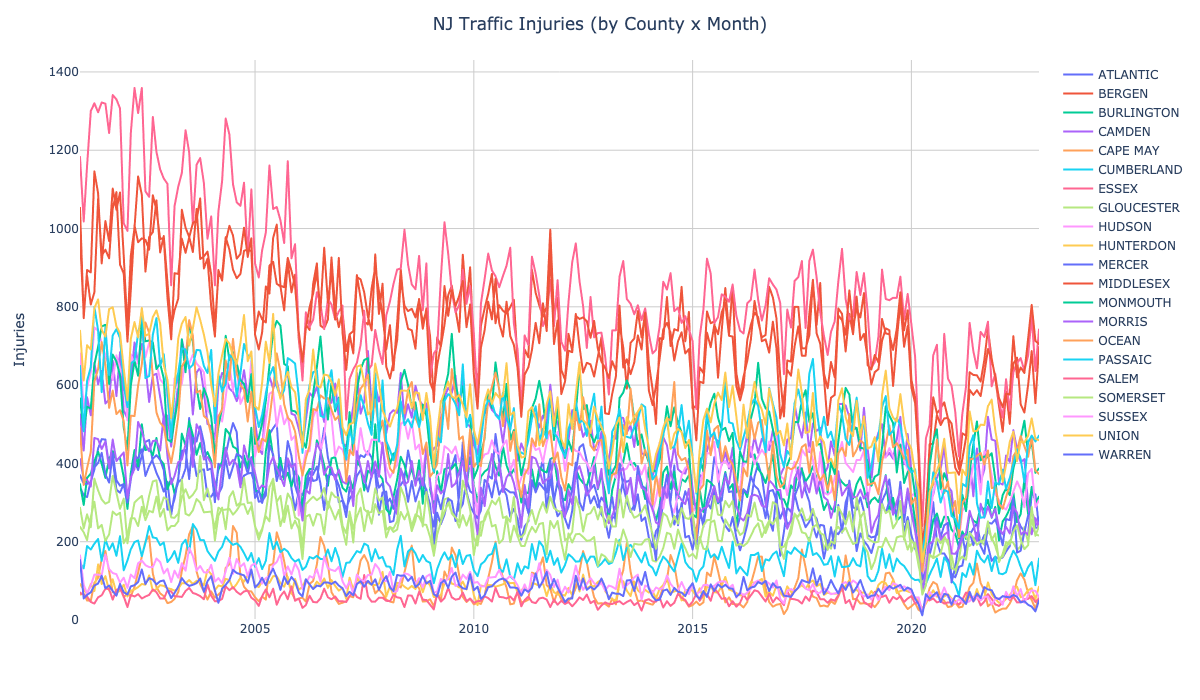

In [14]:
cm_plot(title='NJ Traffic Injuries (by County x Month)', y='Total Injured', yaxis='Injuries', name='icm')

Wrote plot JSON to ../www/public/plots/njdot/pcm.json
Wrote plot image to ../www/public/plots/njdot/pcm.png


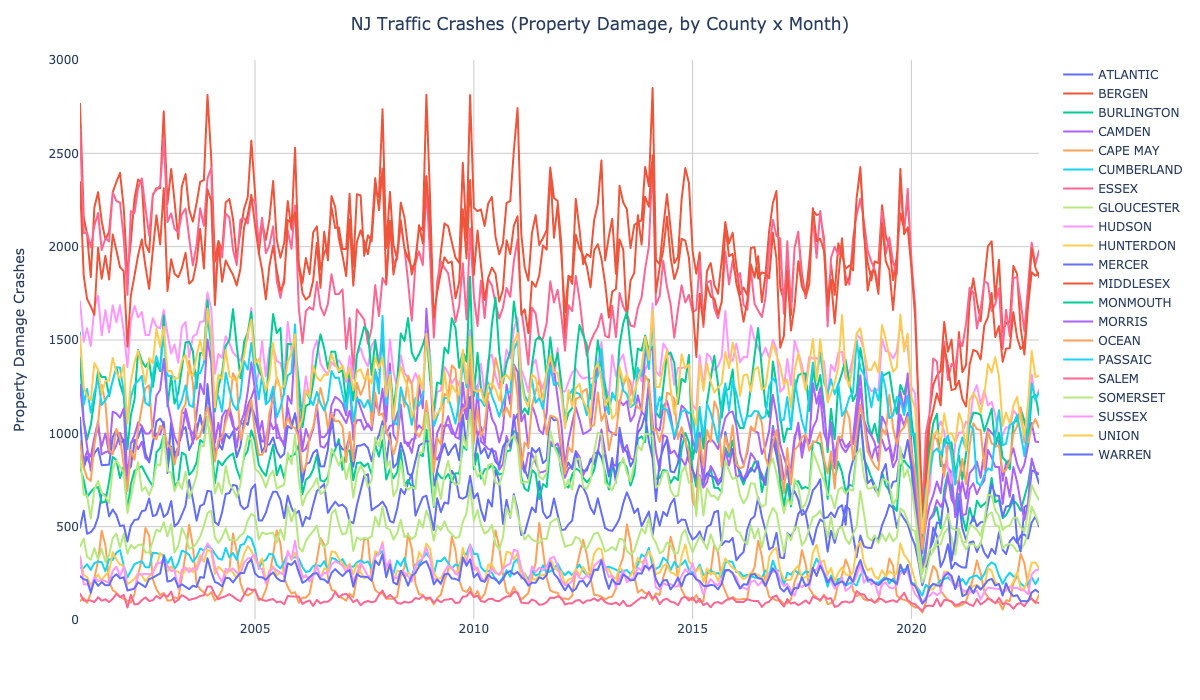

In [15]:
cm_plot(title='NJ Car Crashes (Property Damage, by County x Month)', y='Property Damage', yaxis='Property Damage Crashes', name='pcm')

Wrote plot JSON to ../www/public/plots/njdot/dcm.json
Wrote plot image to ../www/public/plots/njdot/dcm.png


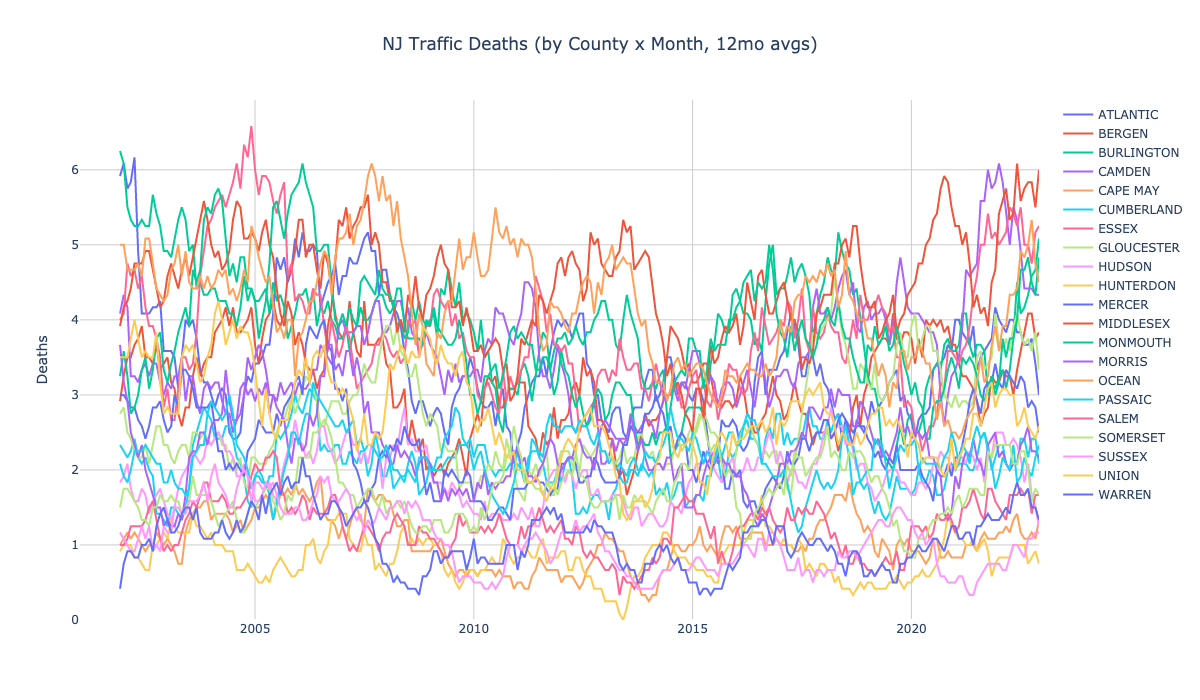

In [16]:
cm_plot(
    title='NJ Traffic Deaths (by County x Month, 12mo avgs)',
    y='Total Killed', yaxis='Deaths',
    name='dcm',
    avgs=True,
    hovertemplate='%{y:.1f}',
)

## Injuries, Property Damage, Deaths (Statewide, by Year)

In [17]:
sy = cm.groupby(cm.Date.dt.year)[keys].sum(0).reset_index().rename(columns={'Date': 'Year'})
sy

,Year,Total Injured,Property Damage,Total Killed
0,2001,116905,230279,726
1,2002,117579,236458,609
2,2003,113997,243578,752
3,2004,112201,243743,738
4,2005,105492,239589,751
5,2006,98261,224942,745
6,2007,95475,237349,710
7,2008,94657,234135,613
8,2009,93562,233294,577
9,2010,92903,232464,567


In [18]:
def sy_plot(title, y, name, w=W, h=H):
    fig = px.bar(
        sy,
        x='Year', y=y,
        labels={ 'Year': '', },
        color_discrete_sequence=['black']
    ).update_xaxes(
        dtick=1,
        tickangle=-45,
    )
    return save(fig, name, title, hovertemplate='%{y:,d}', png=(w, h))

Wrote plot JSON to ../www/public/plots/njdot/isy.json
Wrote plot image to ../www/public/plots/njdot/isy.png


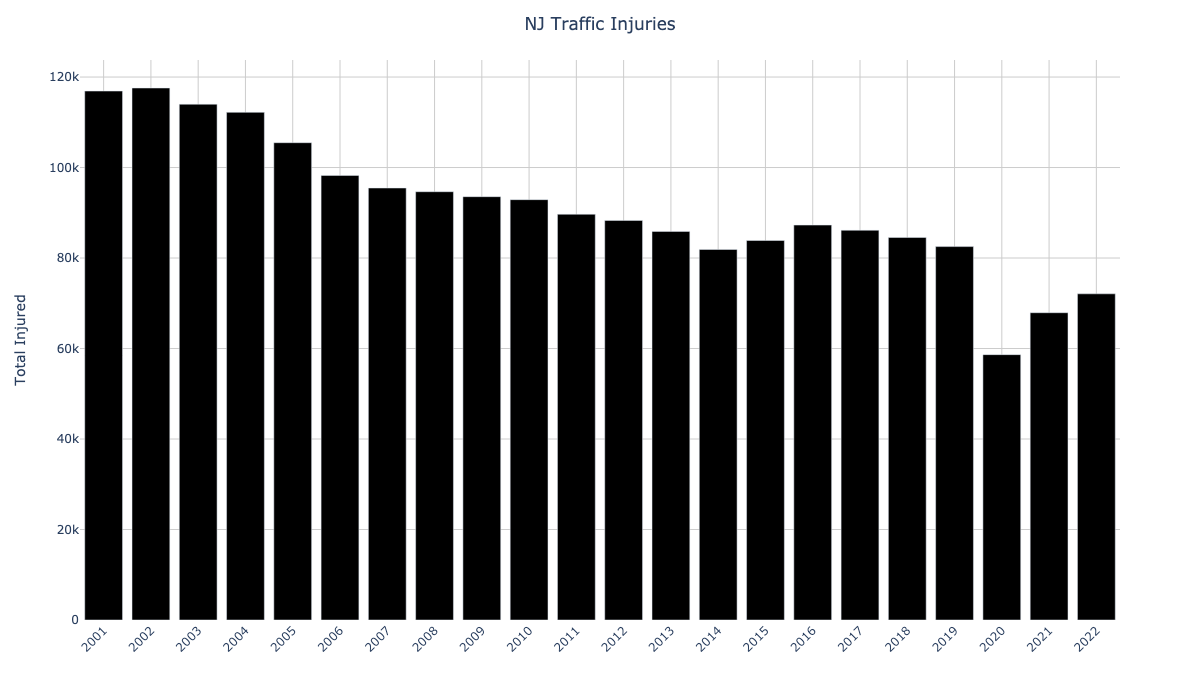

In [19]:
sy_plot(title='NJ Traffic Injuries', y='Total Injured', name='isy')

Wrote plot JSON to ../www/public/plots/njdot/psy.json
Wrote plot image to ../www/public/plots/njdot/psy.png


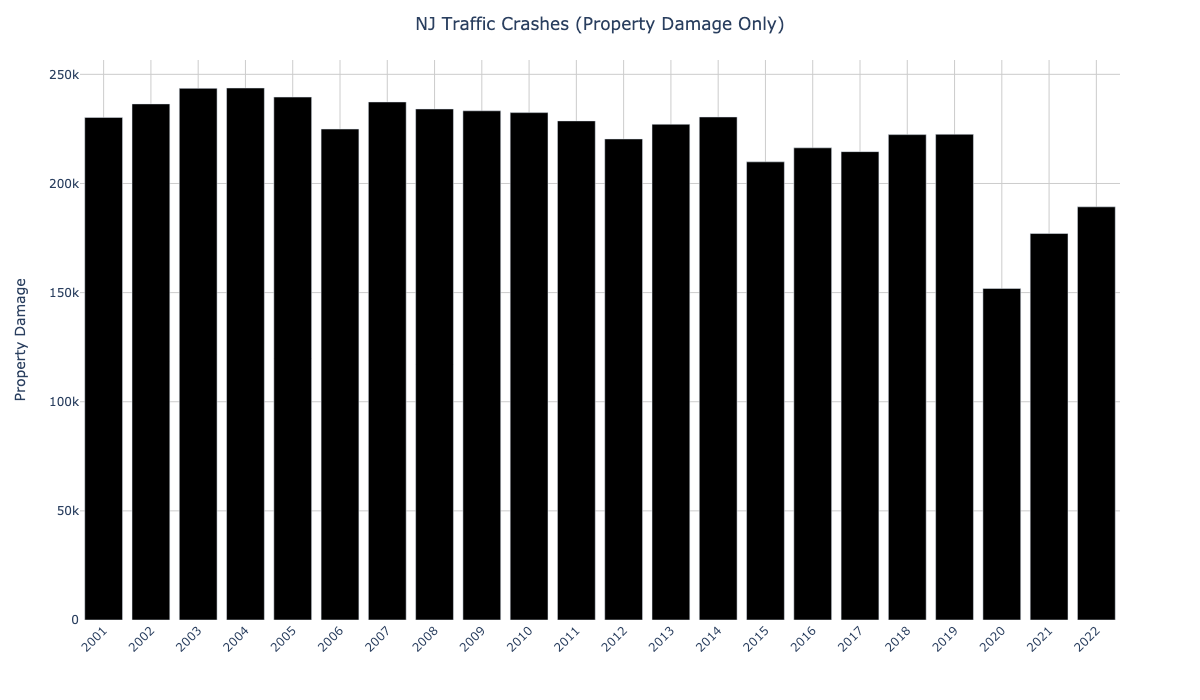

In [20]:
sy_plot(title='NJ Car Crashes (Property Damage Only)', y='Property Damage', name='psy')

Wrote plot JSON to ../www/public/plots/njdot/dsy.json
Wrote plot image to ../www/public/plots/njdot/dsy.png


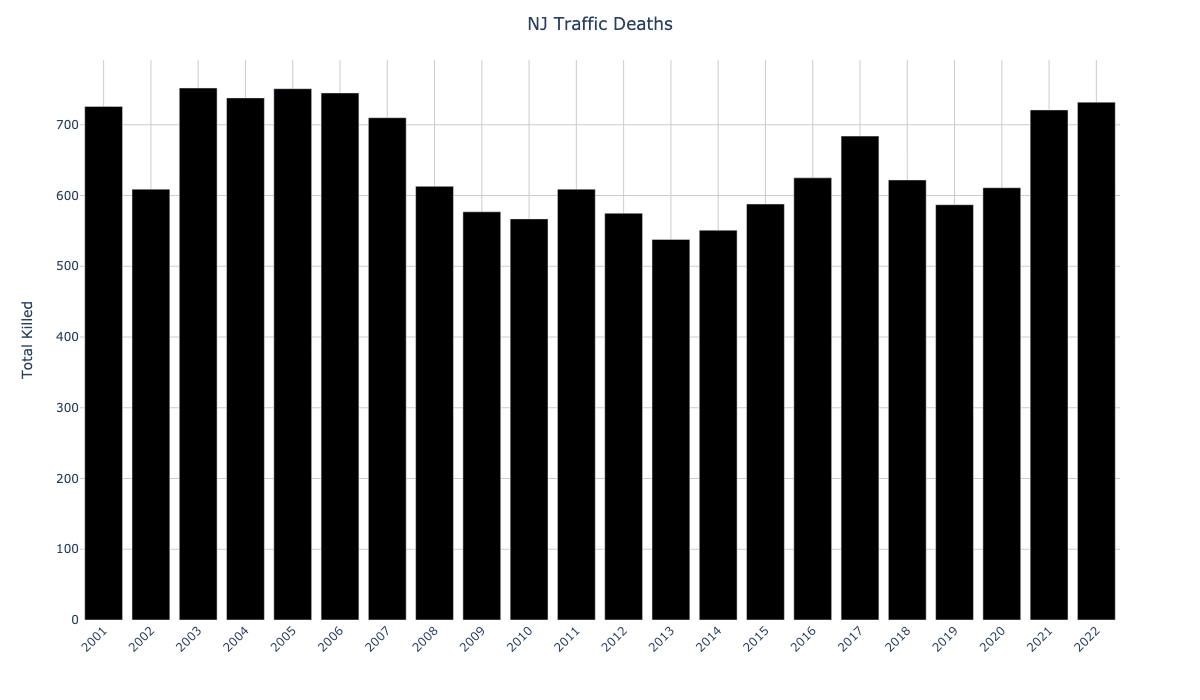

In [21]:
sy_plot(title='NJ Traffic Deaths', y='Total Killed', name='dsy')

## Injuries, Property Damage, Deaths (by County x Year)

In [22]:
cy = cm.groupby([cm.Date.dt.year.rename('Year'), 'County'])[keys].sum(0).reset_index()
cy

,Year,County,Total Injured,Property Damage,Total Killed
0,2001,ATLANTIC,4535,6616,71
1,2001,BERGEN,11982,26619,35
2,2001,BURLINGTON,4642,8828,75
3,2001,CAMDEN,6980,11159,49
4,2001,CAPE MAY,1113,2512,12
...,...,...,...,...,...
457,2022,SALEM,611,1092,20
458,2022,SOMERSET,2498,6740,20
459,2022,SUSSEX,764,2230,14
460,2022,UNION,5336,14124,31


In [23]:
cy[cy.County == 'WARREN']

,Year,County,Total Injured,Property Damage,Total Killed
20,2001,WARREN,1034,2480,5
41,2002,WARREN,1130,2563,18
62,2003,WARREN,1037,2501,13
83,2004,WARREN,1206,2852,19
104,2005,WARREN,1214,2974,22
125,2006,WARREN,1048,2804,18
146,2007,WARREN,1022,3051,9
167,2008,WARREN,1203,2997,7
188,2009,WARREN,1102,2968,10
209,2010,WARREN,1019,2754,12


In [24]:
def cy_plot(title, y, name, w=W, h=H):
    fig = px.line(
        cy[['Year', 'County', y]],
        x='Year', y=y, color='County',
        labels={'Year': ''},
    )    
    return save(fig, name, title, hoverx=True, hovertemplate='%{y:,d}', png=(w, h))

Wrote plot JSON to ../www/public/plots/njdot/icy.json
Wrote plot image to ../www/public/plots/njdot/icy.png


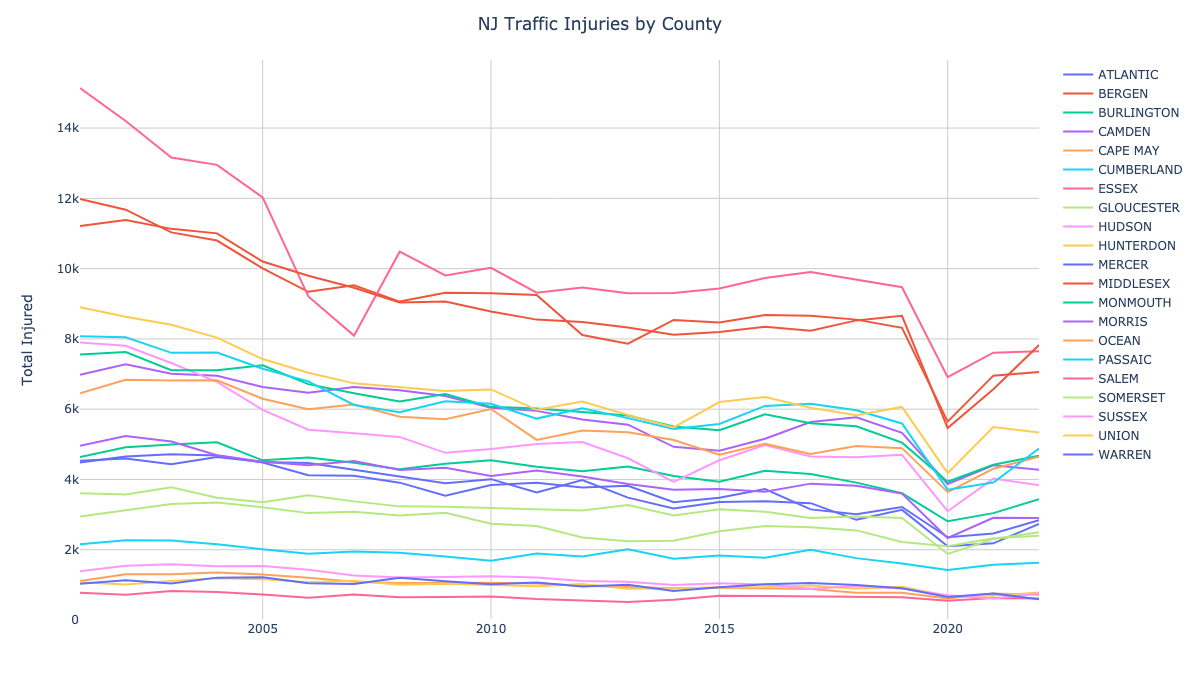

In [25]:
cy_plot(title='NJ Traffic Injuries by County', y='Total Injured', name='icy')

Wrote plot JSON to ../www/public/plots/njdot/pcy.json
Wrote plot image to ../www/public/plots/njdot/pcy.png


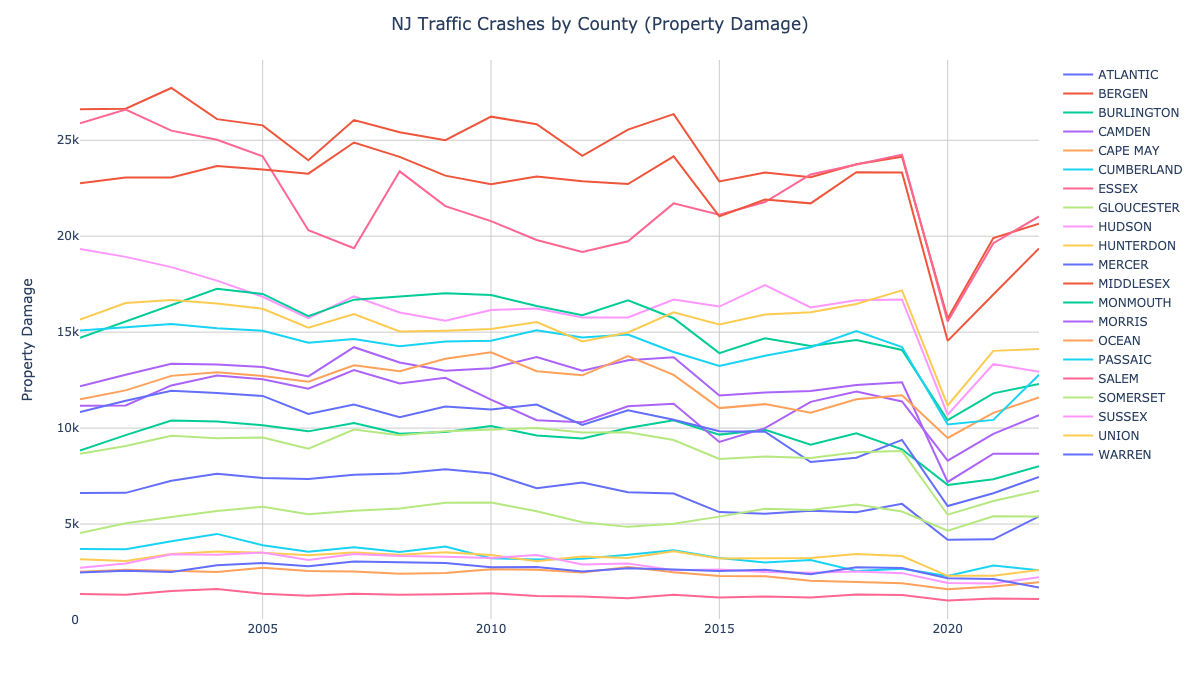

In [26]:
cy_plot(title='NJ Car Crashes by County (Property Damage)', y='Property Damage', name='pcy')

Wrote plot JSON to ../www/public/plots/njdot/dcy.json
Wrote plot image to ../www/public/plots/njdot/dcy.png


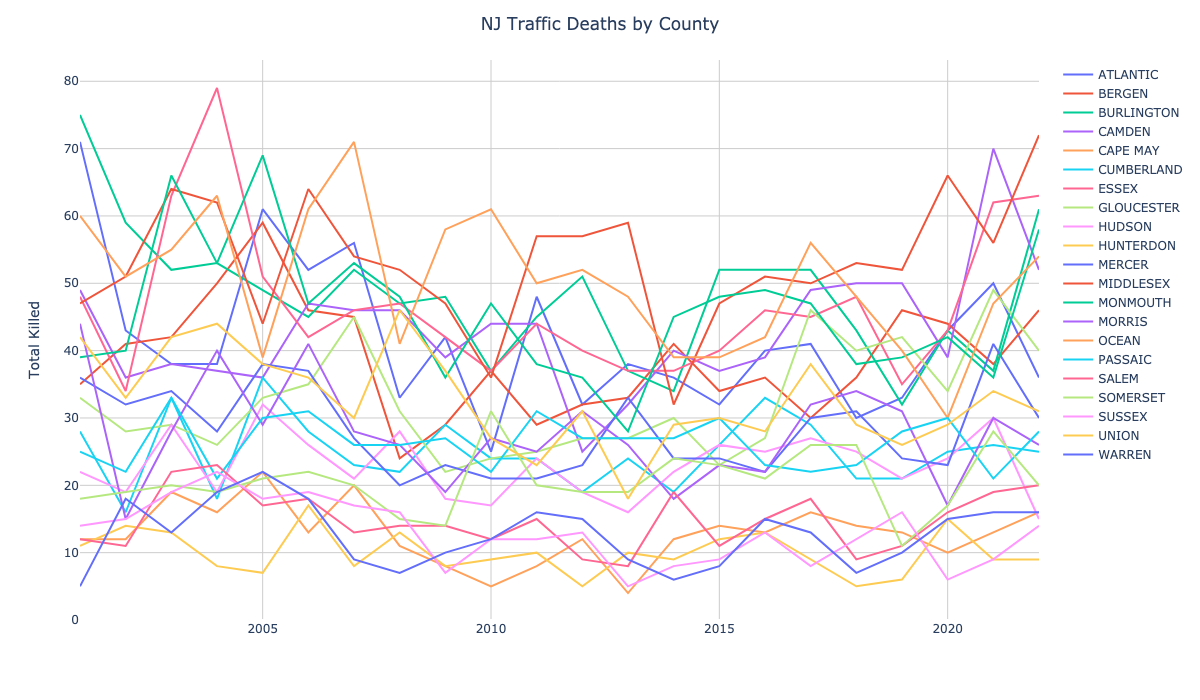

In [27]:
cy_plot(title='NJ Traffic Deaths by County', y='Total Killed', name='dcy')

## Crash Type Percentages

In [28]:
def row_pcts(r):
    total = r.sum()
    return r / total

pcts = sm.apply(row_pcts, axis=1).rename(columns={
    'Total Killed': 'Deaths',
    'Total Injured': 'Injuries'
})[['Deaths', 'Injuries', 'Property Damage']]
pcts

,Deaths,Injuries,Property Damage
Date,,,
2001-01-01,0.001384,0.300406,0.698210
2001-02-01,0.002349,0.297824,0.699827
2001-03-01,0.002470,0.330458,0.667072
2001-04-01,0.001605,0.348510,0.649885
2001-05-01,0.002320,0.357696,0.639984
...,...,...,...
2022-08-01,0.002702,0.301302,0.695996
2022-09-01,0.003092,0.283239,0.713669
2022-10-01,0.002366,0.271761,0.725873


Wrote plot JSON to ../www/public/plots/njdot/pcts_by_type_month.json
Wrote plot image to ../www/public/plots/njdot/pcts_by_type_month.png


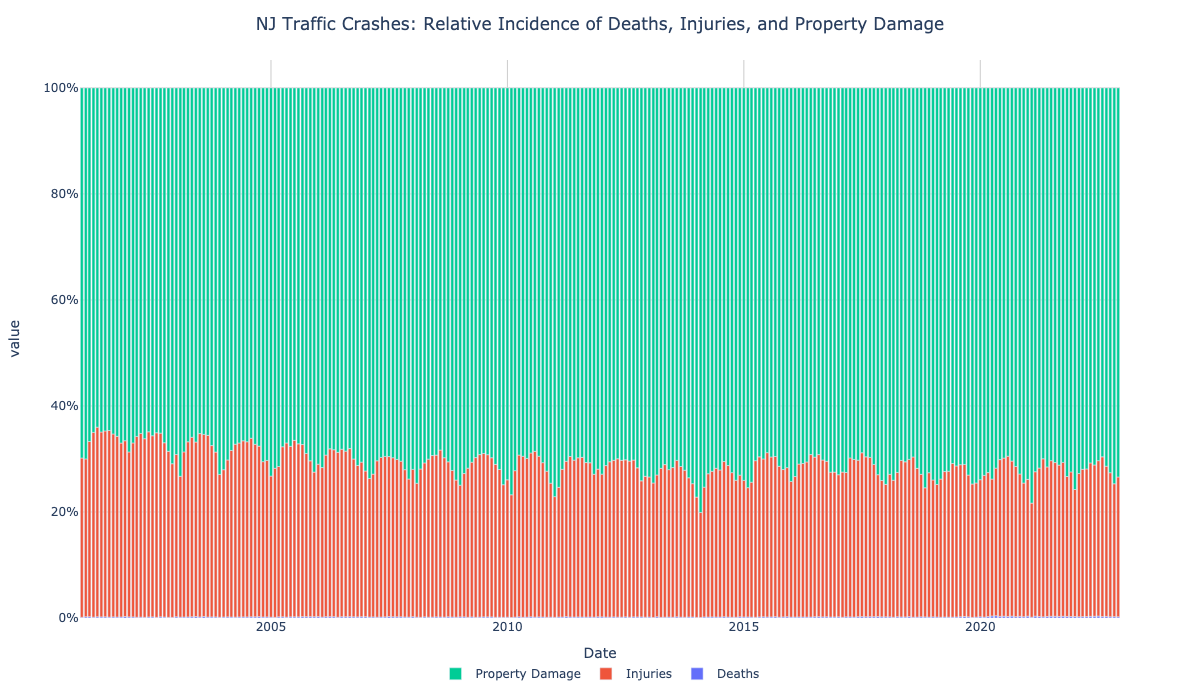

In [29]:
save(
    px.bar(pcts),
    title="NJ Car Crashes: Relative Incidence of Deaths, Injuries, and Property Damage",
    name='pcts_by_type_month',
    hoverx=True,
    hovertemplate='%{y:.1%}',
    yaxis_tickformat='.0%',
    legend=dict(
        traceorder='reversed',
        orientation='h',
        x=0.5,
        xanchor='center',
        yanchor='middle',
    ),
)

Wrote plot JSON to ../www/public/plots/njdot/pct_fatal_by_month.json
Wrote plot image to ../www/public/plots/njdot/pct_fatal_by_month.png


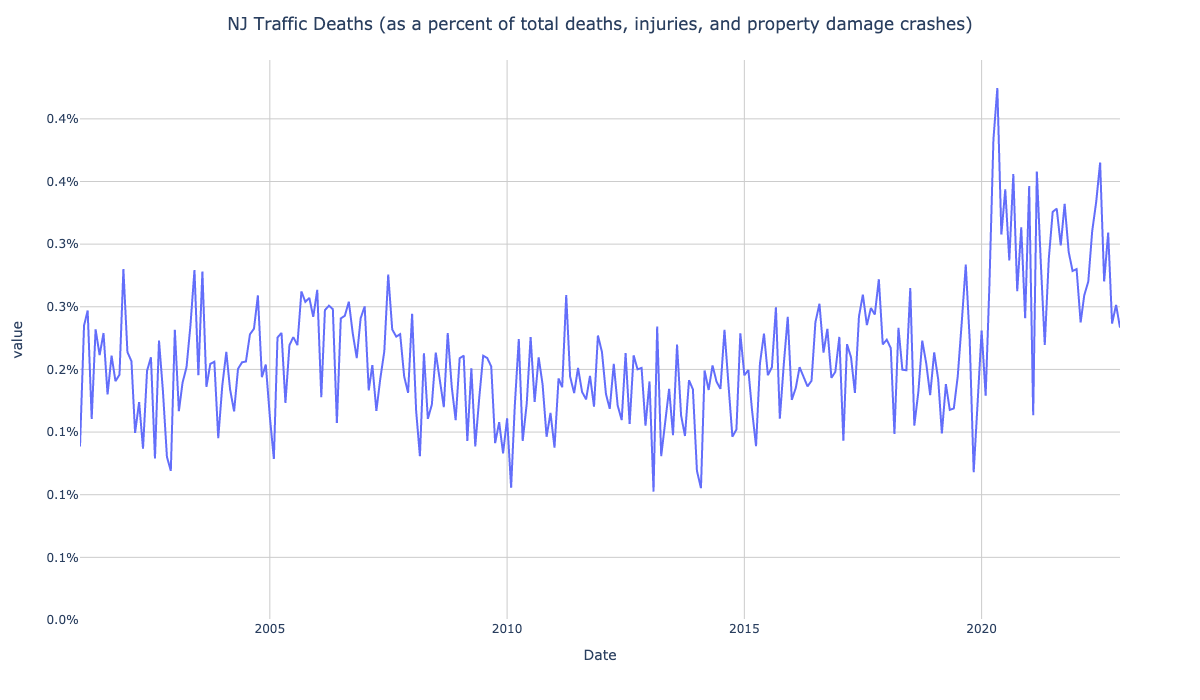

In [30]:
save(
    px.line(pcts.Deaths,),
    title='NJ Traffic Deaths (as a percent of total deaths, injuries, and property damage crashes)',
    name='pct_fatal_by_month',
    showlegend=False,
    hoverx=True,
    hovertemplate='%{y:.1%}',
    yaxis_tickformat='.1%'
)